<a href="https://colab.research.google.com/github/sgr1118/EX/blob/main/%5BExp_13%5D_Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13-9. 프로젝트 - Movielens 영화 추천 실습

- 사용 data : MovieLens 1M Dataset

- 별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.

- 별점을 시청횟수로 해석해서 생각

- 또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [1]:
# 라이브러리 환경 구축
import os, sys

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env2 폴더에 패키지 저장
os.symlink('/content/drive/MyDrive/Colab Notebooks/my_env3', my_path)
sys.path.insert(0, my_path)

In [ ]:
!pip install --target=$my_path implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 1.4 MB/s 
     |████████████████████████████████| 15.7 MB 30.3 MB/s 
     |████████████████████████████████| 78 kB 7.3 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 


# 1) 데이터 준비와 전처리

In [2]:
import numpy as np
import pandas as pd
import scipy
import implicit
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.6
1.3.5
1.7.3
0.6.0


In [90]:
# 데이터 불러오기
rating_file_path = '/content/drive/MyDrive/Aiffel/EX/EX13_file/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

# 전처리가 필요해 보이는 columns은 tomestamp이다.

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [91]:
# 암묵적 데이터 해석 기준
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

# 3점 이상 data는 전체의 83.63%다.

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


[pandas datetime](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)

In [92]:
# timestamp 시간 변환
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings

,user_id,movie_id,ratings,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11
...,...,...,...,...
1000203,6040,1090,3,2000-04-26 02:18:38
1000205,6040,1094,5,2000-04-25 23:21:27
1000206,6040,562,5,2000-04-25 23:19:06
1000207,6040,1096,4,2000-04-26 02:20:48


In [93]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [ ]:
ratings.shape

(836478, 4)

In [172]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path = '/content/drive/MyDrive/Aiffel/EX/EX13_file/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# 여러가지 전처리 시행

(1) title, genre 소문자화

(2) title 연도 삭제

(3) genre에서 '|' 기호 삭제 후 띄어쓰기 추가

(4) 필요없는 공백 삭제 (양측 공백)

(5) , the, a, an 등 title 오른쪽 끝에 공백 삭제

(6) 장르 단어가 최대한 훼손되지 않는 방향으로 시행

[정규표현식 연습 사이트](https://regexr.com/)

In [173]:
import re
def preprocess_sentence_genre(sentence):
  sentence = sentence.str.replace(pat= r'([?.!,¿|])', repl=r' \1', regex=True) #  구두점 분리
  sentence = sentence.str.lower() #  소문자로 바꿔준다.
  sentence = sentence.str.replace(pat=r"[^a-zA-Z!.?'-]+", repl =" ",regex=True) # ^a-zA-Z!.?'- 가 아닌 모든 문자를 하나의 공백으로 바꿉니다
  sentence = sentence.str.replace(pat= r'[" "]+',repl=r" ", regex=True) # 여러개의 공백은 하나의 공백으로 바꿉니다
  return sentence

In [174]:
def preprocess_sentence_title(sentence, remove_stopwords=True):
  sentence = sentence.str.lower() # 소문자로 바꿔준다.
  sentence = sentence.str.replace(pat=r"[(]\d\d\d\d[)]+", repl ="",regex=True) # title 에서 연도 삭제
  sentence = sentence.str.replace(pat= r', the(?= ) +',repl=r" ", regex=True) # 문장 끝에, the 삭제
  sentence = sentence.str.replace(pat= r', an(?= ) +',repl=r" ", regex=True) # 문장 끝에, the 삭제
  sentence = sentence.str.replace(pat= r', a(?= ) +',repl=r" ", regex=True) # 문장 끝에, the 삭제
  sentence = sentence.str.replace(pat= r'[" "]+',repl=r" ", regex=True) # 여러개의 공백은 하나의 공백으로 바꿉니다
  sentence = sentence.str.strip()
  return sentence

In [175]:
movies['genre'] = preprocess_sentence_genre(movies['genre'])

In [176]:
movies['title'] = preprocess_sentence_title(movies['title'])

[]()

In [57]:
movies[movies['title'].str.contains(', the')]

,movie_id,title,genre
1939,2008,"this world, then the fireworks",crime drama film-noir


In [179]:
movies[movies['title'].str.contains(', a')]

,movie_id,title,genre
1169,1186,"sex, lies, and videotape",drama
2820,2889,"mystery, alaska",comedy
2883,2952,"hard 8 (a.k.a. sydney, a.k.a. hard eight)",crime thriller


In [59]:
movies[movies['title'].str.contains(', an')]

,movie_id,title,genre
1169,1186,"sex, lies, and videotape",drama


In [60]:
# 샘플 추출 후 전처리 결과 확인
movies.iloc[2241]	

movie_id      2310
title       mighty
genre        drama
Name: 2241, dtype: object

In [180]:
# ratings 와 movies 데이터 프레임 합치기
ratings = ratings.join(movies.set_index('movie_id'), on='movie_id')
ratings.head(10)

,user_id,movie_id,counts,timestamp,title,genre
0,1,1193,5,2000-12-31 22:12:40,one flew over the cuckoo's nest,drama
1,1,661,3,2000-12-31 22:35:09,james and the giant peach,animation children's musical
2,1,914,3,2000-12-31 22:32:48,my fair lady,musical romance
3,1,3408,4,2000-12-31 22:04:35,erin brockovich,drama
4,1,2355,5,2001-01-06 23:38:11,bug's life,animation children's comedy
5,1,1197,3,2000-12-31 22:37:48,princess bride,action adventure comedy romance
6,1,1287,5,2000-12-31 22:33:59,ben-hur,action adventure drama
7,1,2804,5,2000-12-31 22:11:59,christmas story,comedy drama
8,1,594,4,2000-12-31 22:37:48,snow white and the seven dwarfs,animation children's musical
9,1,919,4,2000-12-31 22:22:48,wizard of oz,adventure children's drama musical


In [181]:
# 결측치 확인
ratings.info()
print(ratings.isnull().sum())

# 결측치가 없음을 확인하였다.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 836478 entries, 0 to 1000208
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    836478 non-null  int64         
 1   movie_id   836478 non-null  int64         
 2   counts     836478 non-null  int64         
 3   timestamp  836478 non-null  datetime64[ns]
 4   title      836478 non-null  object        
 5   genre      836478 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 44.7+ MB
user_id      0
movie_id     0
counts       0
timestamp    0
title        0
genre        0
dtype: int64


# 2) 분석해 봅시다.

- ratings에 있는 유니크한 영화 개수
- ratings에 있는 유니크한 사용자 수
- 가장 인기 있는 영화 30개(인기순)

In [ ]:
# ratings에 있는 유니크한 영화 개수
print(ratings['movie_id'].nunique())

# 총 3628개의 영화가 있다.

3628


In [ ]:
# ratings에 있는 유니크한 사용자 수
print(ratings['user_id'].nunique())

# 총 6039명의 사용자가 있다.

6039


In [182]:
# 가장 인기 있는 영화 30개(인기순)
movies_count = ratings.groupby(by = ['movie_id', 'title'])['user_id'].count()
movies_count.sort_values(ascending=False).head(30)

movie_id  title                                         
2858      american beauty                                   3211
260       star wars: episode iv - a new hope                2910
1196      star wars: episode v - the empire strikes back    2885
1210      star wars: episode vi - return of the jedi        2716
2028      saving private ryan                               2561
589       terminator 2: judgment day                        2509
593       silence of the lambs                              2498
1198      raiders of the lost ark                           2473
1270      back to the future                                2460
2571      matrix                                            2434
480       jurassic park                                     2413
2762      sixth sense                                       2385
608       fargo                                             2371
110       braveheart                                        2314
1580      men in black           

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해 줍시다.

In [183]:
# 내가 좋아하는 영화 목록 딕셔너리 만들기
my_favorite = {2571:'matrix', 1580:'men in black', 2716:'ghostbusters', 1240:'terminator', 1:'toy story'}

(1) [extend 사용 이유](https://m.blog.naver.com/wideeyed/221541104629)

In [184]:
# 영화 제목으로 장르 추출하는 함수
# my_favorite에서 value값을 가져와 타이틀과 일치하면 장르를 추출하여 genres_of_my_favorite에 리스트로 저장

def get_genre_of_movie(my_favorite):
    genres_of_my_favorite = []
    for k, v in my_favorite.items():
        genres_of_my_favorite.extend(movies[movies['title'] == v]['genre'].to_list())
    return genres_of_my_favorite

In [191]:
# my_favorite의 장르 확인
get_genre_of_movie(my_favorite)

['action sci-fi thriller',
 'action adventure comedy sci-fi',
 'comedy horror',
 'action sci-fi thriller',
 "animation children's comedy"]

In [88]:
# 오류 1
# my_favorite의 장르 확인에서 장르가 5개의 문자열이 추출되어야하는데 6개가 추출되었다.
# 이는 다른 영화였지만 전처리를 거치면서 같은 이름으로 전처리가 되었을 가능성이 높다.
# 실제로 위에서 예상한 것처럼 Toy Story라는 영화가 전처리를 거친 후 전부 toy story가 된것이다.
movies[movies['title'].str.contains('Toy')]

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1948,2017,Babes in Toyland (1961),Children's|Fantasy|Musical
2184,2253,Toys (1992),Action|Comedy|Fantasy
3017,3086,March of the Wooden Soldiers (a.k.a. Laurel & ...,Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy


In [89]:
# 이 title을 가진 영화는 존재하지 않는 것으로 판단된다.
ratings[ratings['title'] == 'toy story 2']

,user_id,movie_id,counts,timestamp,title,genre


In [178]:
# # 오류 1 문제 해결
movies[movies['title'].str.contains('toy s')]

,movie_id,title,genre
0,1,toy story,animation children's comedy
3045,3114,toy story 2,animation children's comedy


ValueError: All arrays must be of the same length 오류가 뜨는 원인

- title에서 연도만 전처리를 하길 원했으나 [(0-9)]는 모든 숫자를 전처리해버렸다. 그래서 [(]\d\d\d\d[)]로 조건을 주어 () 안에 숫자를 1개씩 지우는데 성공하였다.

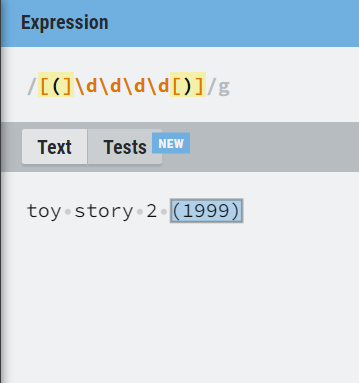


In [186]:
# 현재 시간
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

# 영화 데이터의 이름은 반드시 데이터셋이랑 일치해야한다.
# user_id의 마지막이 6040이므로 6041로 추가해준다

my_list = pd.DataFrame({
    'user_id': [6041]*5,
    'movie_id': my_favorite.keys(),
    'counts': [3,4,4,5,5],
    'timestamp': [now]*5,
    'title': my_favorite.values(),
    'genre': get_genre_of_movie(my_favorite)})

if not ratings.isin({'user_id':[6041]})['user_id'].any():
  ratings = ratings.append(my_list)  
# # user_id에 '6041'이라는 데이터가 없다면  위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

ratings.tail(10)

,user_id,movie_id,counts,timestamp,title,genre
1000203,6040,1090,3,2000-04-26 02:18:38,platoon,drama war
1000205,6040,1094,5,2000-04-25 23:21:27,crying game,drama romance war
1000206,6040,562,5,2000-04-25 23:19:06,welcome to the dollhouse,comedy drama
1000207,6040,1096,4,2000-04-26 02:20:48,sophie's choice,drama
1000208,6040,1097,4,2000-04-26 02:19:29,e.t. the extra-terrestrial,children's drama fantasy sci-fi
0,6041,2571,3,2022-09-05 14:28:27,matrix,action sci-fi thriller
1,6041,1580,4,2022-09-05 14:28:27,men in black,action adventure comedy sci-fi
2,6041,2716,4,2022-09-05 14:28:27,ghostbusters,comedy horror
3,6041,1240,5,2022-09-05 14:28:27,terminator,action sci-fi thriller
4,6041,1,5,2022-09-05 14:28:27,toy story,animation children's comedy


모델에 활용하기 위한 전처리 

user_id와 movie 각각에 번호를 붙이는 indexing 진행

In [187]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = ratings['user_id'].unique()
# movie_unique = ratings['movie_id'].unique()
movie_unique = ratings['title'].unique()

# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
movie_to_idx = {v:k for k,v in enumerate(movie_unique)}

In [189]:
# indexing 결과 확인
print(user_to_idx[6041]) 
print(movie_to_idx['terminator'])

# 6040명의 유저 중 마지막으로 추가된 유저이니 6039가 나와야 합니다.

6039
200


In [190]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 

temp_user_ratings = ratings['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_ratings) == len(ratings):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user_id column indexing OK!!')
    ratings['user_id'] = temp_user_ratings   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

# artist_to_idx을 통해 artist 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_ratings = ratings['title'].map(movie_to_idx.get).dropna()
if len(temp_movie_ratings) == len(ratings):
    print('movie column indexing OK!!')
    ratings['movie_id'] = temp_movie_ratings
else:
    print('movie column indexing Fail!!')
ratings

user_id column indexing OK!!
movie column indexing OK!!


,user_id,movie_id,counts,timestamp,title,genre
0,0,0,5,2000-12-31 22:12:40,one flew over the cuckoo's nest,drama
1,0,1,3,2000-12-31 22:35:09,james and the giant peach,animation children's musical
2,0,2,3,2000-12-31 22:32:48,my fair lady,musical romance
3,0,3,4,2000-12-31 22:04:35,erin brockovich,drama
4,0,4,5,2001-01-06 23:38:11,bug's life,animation children's comedy
...,...,...,...,...,...,...
0,6039,124,3,2022-09-05 14:28:27,matrix,action sci-fi thriller
1,6039,175,4,2022-09-05 14:28:27,men in black,action adventure comedy sci-fi
2,6039,243,4,2022-09-05 14:28:27,ghostbusters,comedy horror
3,6039,200,5,2022-09-05 14:28:27,terminator,action sci-fi thriller


# 4) CSR matrix를 직접 만들어 봅시다.

- 매우 커진 평가행렬 용량은 CSR matrix를 사용하면 최소한의 사용량으로 Sparse한 matrix와 동일한 행렬을 표현 가능하다.

In [196]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings.counts, (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data

<6040x3579 sparse matrix of type '<class 'numpy.int64'>'
	with 833986 stored elements in Compressed Sparse Row format>

# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜 봅시다.

[implicit](https://github.com/benfred/implicit)

- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지

- 이 패키지에 구현된 als
(AlternatingLeastSquares) 모델을 사용

- Matrix Factorization에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

In [197]:
# als 모델 불러오기
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

AlternatingLeastSquares 클래스의 __init__ 파라미터를 살펴보겠습니다.

(1) factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지

(2) regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지

(3) use_gpu : GPU를 사용할 것인지

(4) iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지

In [198]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=200, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [199]:
als_model.fit(csr_data)

  0%|          | 0/15 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

In [203]:
# user와 movie의 벡터 구하기
user, terminator = user_to_idx[6041], movie_to_idx['terminator']
user_vector, terminator_vector = als_model.user_factors[user], als_model.item_factors[terminator]

In [204]:
# user와 movie를 내적하는 코드
np.dot(user_vector, terminator_vector)

# 0.57352877 
# 'terminator'는 선호하는 영화였지만 수치가 약 0.57이 나왔다. 
# 1에 가깝게 나와야했으나 학습 결과가 아깝다.
# factors를 늘리거나 iterations를 늘려야 할 것 같습니다.

0.57352877

In [206]:
# 한번 더 선호도 비교해보기
toystory = movie_to_idx['toy story']
toystory_vector = als_model.item_factors[toystory]
np.dot(user_vector, toystory_vector)

# 0.6752075
# 'terminator' 보다는 보다 좀 더 높게 나왔다.

0.6752075

내적 벡터의 수치는 모델을 만드는 사람이 어느 정도 수치를 긍정적으로 볼 것인지에 따라 다르다. 추천 시스템은 다른 머신러닝 분석보다 객관적인 평가를 하기 힘들다.

# 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

- - similar_items 메서드를 통하여 내가 좋아하는 영화와 비슷한 영화를 찾습니다.



In [223]:
favorite_movie = 'terminator'
movie_title = movie_to_idx[favorite_movie]
similar_movie_idx, similar_movie = als_model.similar_items(movie_title, N=15)
 # lms에서는 그냥 튜플로 나오지만 이 버전에서는 리턴이 두개로 나옵니다 :)
print(similar_movie_idx)
print(similar_movie)
tuple_similar_movie = [(similar_movie_idx[i], similar_movie[i]) for i in range(15)]

[ 200  647   92  194  193  858  124  921   62  676  875  117  172 2068
 2921]
[1.0000001  0.65415037 0.6250364  0.59156525 0.52558225 0.52020043
 0.44011515 0.43303365 0.39247212 0.37215436 0.36350393 0.36131033
 0.3601549  0.3560355  0.3518998 ]


In [224]:
# movie_to_idx 를 뒤집어, index로부터 artist 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in tuple_similar_movie]

# 선호하는 유형과 유사한 영화 : terminator, aliens, terminator 2: judgment day, alien, predator, matrix
# 꽤 유사하게 나온것을 알 수 있음.

['terminator',
 'aliens',
 'terminator 2: judgment day',
 'die hard',
 'alien',
 'predator',
 'matrix',
 'robocop',
 'total recall',
 'blade runner',
 'mad max 2 (a.k.a. the road warrior)',
 'star wars: episode v - the empire strikes back',
 'indiana jones and the last crusade',
 'career girls',
 'shattered image']

In [256]:
# 반복적인 확인을 위해 함수 구현
def get_similar_movie(movie_name: str):
    movie_title = movie_to_idx[movie_name]
    similar_movie_idx, similar_movie = als_model.similar_items(movie_title, N=15)
    similar_movie = [idx_to_movie[i] for i in similar_movie_idx]
    return similar_movie

In [261]:
get_similar_movie('terminator')

['terminator',
 'aliens',
 'terminator 2: judgment day',
 'die hard',
 'alien',
 'predator',
 'matrix',
 'robocop',
 'total recall',
 'blade runner',
 'mad max 2 (a.k.a. the road warrior)',
 'star wars: episode v - the empire strikes back',
 'indiana jones and the last crusade',
 'career girls',
 'shattered image']

# 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

- recommend 메서드를 통하여 제가 좋아할 만한 아티스트를 추천받습니다. filter_already_liked_items 는 유저가 이미 평가한 아이템은 제외하는 Argument입니다.

In [262]:
user = user_to_idx[6041]
movie_recommended_idx, movie_recommended = als_model.recommend(user, csr_data[user], N=15, filter_already_liked_items=True)
tuple_movie_recommended = [(movie_recommended_idx[i], movie_recommended[i]) for i in range(15)]
tuple_movie_recommended

[(92, 0.70401835),
 (62, 0.39430207),
 (107, 0.331925),
 (50, 0.3178971),
 (647, 0.2921992),
 (22, 0.28704047),
 (4, 0.25424233),
 (38, 0.2468125),
 (193, 0.23300958),
 (141, 0.23028316),
 (666, 0.21198219),
 (117, 0.20620136),
 (985, 0.19806173),
 (194, 0.1950492),
 (145, 0.19079298)]

In [263]:
[idx_to_movie[i[0]] for i in tuple_movie_recommended]

# 가장 추천을 해주고 있는것은 'terminator 2: judgment day'이다.

['terminator 2: judgment day',
 'total recall',
 'jurassic park',
 'toy story 2',
 'aliens',
 'back to the future',
 "bug's life",
 'sixth sense',
 'alien',
 'fugitive',
 'galaxy quest',
 'star wars: episode v - the empire strikes back',
 'shining',
 'die hard',
 'fifth element']

In [265]:
# 'terminator 2: judgment day'가 추천에 기여한 정도를 확인해보기
# 이 method는 추천한 콘텐츠의 점수에 기여한 다른 콘텐츠와 기여도(합이 콘텐츠의 점수가 됩니다.)를 반환합니다.

terminator2 = movie_to_idx['terminator 2: judgment day']
explain = als_model.explain(user, csr_data, itemid=terminator2)

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('terminator', 0.32060944915755096),
 ('matrix', 0.21981300995186617),
 ('men in black', 0.13291993309756622),
 ('toy story', 0.0256587843729875),
 ('ghostbusters', -0.004531121999265157)]

# 회고

1. 이번 프로젝트에서 어려웠던 점
 
 (1) movie 파일에서 title과 genre의 문자 전처리가 쉽지 않았습니다. 사실 전처리가 필요한 프로젝트가 아니었지만 만약 필요하다면 어땠을까? 라는 생각을하여 진행하였습니다.

 (2) 전처리 후 예상하지 못한 변수가 많았습니다. 예를들어 Toy Story (1995)와 Toy Story 2 (1998)이 있을때 전처리 후 둘 다 toy story가 되어버려 데이터 분석에서 계속 오류가 발생했습니다.

2. 프로젝트를 진행하면서 알게된 부분 또는 아직 이해하지 못한 부분

(1) 낯설었던 정규표현식 사용법에 조금 더 다가가게되었습니다.

- 문자, 기호, 숫자가 혼합된 Data를 전처리 해본 경우가 처음이라 예상치 못한 오류가 많았으나 정규표현식 적용을 연습 할 수 있는 사이트에서 연습하여 잘 완료 할 수 있었습니다.





참조

(1) [정규표현식 참조](http://pythonstudy.xyz/python/article/401-%EC%A0%95%EA%B7%9C-%ED%91%9C%ED%98%84%EC%8B%9D-Regex)

(2) [정규표현식 연습](https://regexr.com/)

